In [3]:
import pandas as pd
from modules import components
from unidecode import unidecode
import numpy as np
import itertools
import re

import scipy
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

# from adjustText import adjust_text
# import textalloc as ta


from yellowbrick.cluster import KElbowVisualizer # cluster visualizer

from sklearn.cluster import KMeans
# from sklearn.metrics.cluster import contingency_matrix
# from sklearn.cluster import AgglomerativeClustering


In [2]:
# !pip install adjustText
# !pip install textalloc

# !!!Dont Touch!!!

### canto - character - occurences


In [2]:

ch = components.get_char_list()[0]
characters = [unidecode(c.lower()) for c in ch]
len(ch)


838

In [3]:
df = pd.read_csv("../data/csv/c_b_t.csv", encoding='utf-8')
df['Text'] = df['Text'].apply(lambda x : re.sub("'s", "", (x)))

df.head(6)

,Chapter,Book,Text
0,Invocation,Book,"Praise to Válmíki,(2)bird of charming song,(3)..."
1,Canto I. Nárad.,Book I.,"OM.(8) To sainted Nárad, prince of those Wh..."
2,Canto II. Brahmá's Visit,Book I.,"Válmíki, graceful speaker, heard, To highest..."
3,Canto III. The Argument.,Book I.,The hermit thus with watchful heed Received ...
4,Canto IV. The Rhapsodists.,Book I.,"When to the end the tale was brought, Rose i..."
5,Canto V. Ayodhyá.,Book I.,"""Ikshváku sons from days of old Were ever br..."


In [4]:
canto= [] 
person = []
occ = []

for idx, row in df.iterrows():
    txt = unidecode(row["Text"].strip().lower()).split()
    d = {}
    for word in txt:
        if word in characters:
            if word in d:
                d[word] += 1
            else:
                d[word] = 1
    for key in d:
        canto.append(idx)
        person.append(key)
        occ.append(d[key])
    
len(canto) == len(person) == len(occ)

True

In [5]:
cpo = pd.DataFrame(list(zip(canto, person, occ)), columns=['Canto', 'Person', 'Occurences'])
# cpo.to_csv("../data/csv/cpo.csv", index=False)
cpo.to_csv("../data/csv/clusts.csv", index=False)

# The Real Stuff

In [11]:
cpo = pd.read_csv("../data/csv/clusts.csv")
cpo.tail()

,Canto,Person,Occurences,Normalised,Values,freq_norm,Value_norm,Person_num,CantoTotal,occ_freq
4083,493,manu,1,0.142857,0.142857,0.142857,0.020408,244,45,0.022222
4084,493,mahendra,1,0.071429,0.071429,0.062500,0.004464,229,45,0.022222
4085,493,angad,1,0.020833,0.020833,0.010309,0.000215,23,45,0.022222
4086,493,bali,1,0.017241,0.017241,0.007463,0.000129,53,45,0.022222
4087,493,hanuman,1,0.015152,0.015152,0.009804,0.000149,130,45,0.022222


In [12]:
cpo.Person.nunique()

488

In [18]:
norm = {}
normalised_li = []
#normalise: occurence of a character over cantos, summing to 1
for i in range(cpo.Person.nunique()):
    pers = cpo.Person.value_counts().index.to_list()[i]
    dist = (1/cpo.Person.value_counts()[i])
    norm[pers] = dist
pers_list = cpo["Person"]
for i in range(len(pers_list)):
    normalised_li.append(norm[pers_list[i]])
cpo.drop('Normalised', axis=1, inplace=True)
cpo.insert(3, "Normalised", normalised_li, True)


In [20]:
cpo["Values"] = cpo["Occurences"] * cpo["Normalised"]
#normalised, I take to be a weight -ie., compared to how many chapters the character appears in, 
# how important are you to treat the occurences in 1

#or maybe it should be that the frequency of occurences defines the chapter importance
# ie., calculate weight of a chapter for a character, compared to their occurences in all others
#  ie., normalise occ freq too, in that -> norm = (occurences/total occurences in book)

In [25]:
freq_count = {}
norms = []
for idx, row in cpo.iterrows():
    if row["Person"] in freq_count:
        freq_count[row["Person"]] += row["Occurences"]
    else:
        freq_count[row["Person"]] = row["Occurences"]

for idx, row in cpo.iterrows():
    norms.append(row["Occurences"]/freq_count[row["Person"]])

cpo.drop('freq_norm', axis=1, inplace=True)

cpo.insert(5, "freq_norm",norms, True)

In [28]:
cpo["Value_norm"] = cpo["freq_norm"] * cpo["Normalised"]


In [29]:
i=0
df = cpo[cpo["Canto"] == i]
df.shape[0]

2

In [30]:
cpo['Person_num'] = pd.Categorical(cpo['Person']).codes



In [34]:
#adding total character occurences in canto
canto_occs = []
for i in range(0, 494):
    df = cpo[cpo["Canto"] == i]
    for j in range(df.shape[0]):
        canto_occs.append(df["Occurences"].sum())
# len(canto_occs)
cpo.drop("CantoTotal", axis=1, inplace=True)
cpo.insert(8, "CantoTotal", canto_occs, True) 

In [35]:
cpo.head()

,Canto,Person,Occurences,Normalised,Values,freq_norm,Value_norm,Person_num,CantoTotal,occ_freq
0,0,valmiki,1,0.250000,0.250000,0.111111,0.027778,435,4,0.250000
1,0,rama,3,0.002717,0.008152,0.002151,0.000006,312,4,0.750000
2,1,rama,26,0.002717,0.070652,0.018638,0.000051,312,78,0.333333
3,1,vishnu,1,0.025000,0.025000,0.016667,0.000417,466,78,0.012821
4,1,kaikeyi,1,0.014493,0.014493,0.008475,0.000123,161,78,0.012821


In [36]:
cpo["occ_freq"] = cpo["Occurences"] / cpo["CantoTotal"] #importance of character to chapter

In [37]:
cpo.head()
# cpo.shape

,Canto,Person,Occurences,Normalised,Values,freq_norm,Value_norm,Person_num,CantoTotal,occ_freq
0,0,valmiki,1,0.250000,0.250000,0.111111,0.027778,435,4,0.250000
1,0,rama,3,0.002717,0.008152,0.002151,0.000006,312,4,0.750000
2,1,rama,26,0.002717,0.070652,0.018638,0.000051,312,78,0.333333
3,1,vishnu,1,0.025000,0.025000,0.016667,0.000417,466,78,0.012821
4,1,kaikeyi,1,0.014493,0.014493,0.008475,0.000123,161,78,0.012821


### HClust

In [54]:
cpo = pd.read_csv("../data/csv/clusts.csv")

In [55]:
r = (
 cpo.query("Canto == 300"))
r.head()

,Canto,Person,Occurences,Normalised,Values,freq_norm,Value_norm,Person_num,CantoTotal,occ_freq
2663,300,rama,1,0.002717,0.002717,0.000717,0.000002,312,15,0.066667
2664,300,sugriva,3,0.010000,0.030000,0.011278,0.000113,379,15,0.200000
2665,300,janak,1,0.016667,0.016667,0.011765,0.000196,150,15,0.066667
2666,300,raghu,2,0.004545,0.009091,0.005038,0.000023,309,15,0.133333
2667,300,indra,2,0.006369,0.012739,0.008658,0.000055,141,15,0.133333


In [56]:
# canto_ppl = cpo.drop_duplicates('Person')
# canto_ppl.head()
# t = cpo.query("Person == 'lakshman' or Person == 'rama'").query("Canto == 492")
# t

In [57]:
r.Person.shape

(11,)

In [58]:
len(list(itertools.combinations(range(len(r["Person"])),2)))
# nC2 for 1D condensed distance matrix for input y: maps distances between various points: in this case the chars
# len(list(itertools.combinations(range(len(canto_ppl["Person"])),2)))


55

In [59]:
occ = r.Values.to_list()
chap = r.Canto.to_list()
labels = r.Person.to_list()

#need condensed distance matrix
x = np.array([[occ[i]] for i in range(len(occ))])

#NOT WORKING - why the same hclust op for x and cond_mat both?

cond_mat = scipy.spatial.distance.pdist(x)
len(cond_mat)


55

In [60]:
hclust = sch.linkage(cond_mat)
hclust[0]

array([2.00000000e+00, 1.00000000e+01, 5.74712644e-04, 2.00000000e+00])

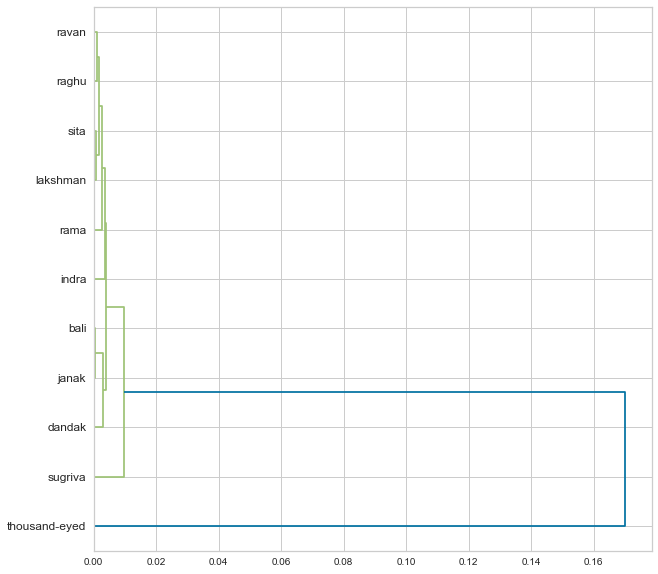

In [61]:
plt.figure(figsize=(10,10))

dend = sch.dendrogram(hclust, labels=labels, orientation='right') #leaf-rotation

In [24]:
# Y = canto_ppl.Values.to_numpy()
# Y_d = np.reshape(Y, (len(Y), 1))
# link_mat = sch.linkage(Y_d)
# link_mat.shape
# # Y_d.shape

In [25]:
# Z = link_mat[:20]
# Z.shape


In [26]:
# plt.figure(figsize=(100,10))
# dend = sch.dendrogram(link_mat, labels=label_list)
# # dend = sch.dendrogram(link_mat, p=5, truncate_mode='lastp', labels=label_list)#truncating

In [27]:
# complete_clustering = sch.linkage(Y_d, method="complete", metric="euclidean")
# average_clustering = sch.linkage(Y_d, method="average", metric="euclidean")
# single_clustering = sch.linkage(Y_d, method="single", metric="euclidean")


In [28]:
# plt.figure(figsize=(10,10))
# sch.dendrogram(complete_clustering)
# plt.show()

## KMeans

In [29]:
cpo.head()

,Canto,Person,Occurences,Normalised,Values,freq_norm,Value_norm,Person_num,CantoTotal,occ_freq
0,0,valmiki,1,0.250000,0.250000,0.111111,0.027778,435,4,0.250000
1,0,rama,3,0.002717,0.008152,0.002151,0.000006,312,4,0.750000
2,1,rama,26,0.002717,0.070652,0.018638,0.000051,312,78,0.333333
3,1,vishnu,1,0.025000,0.025000,0.016667,0.000417,466,78,0.012821
4,1,kaikeyi,1,0.014493,0.014493,0.008475,0.000123,161,78,0.012821


In [31]:
cpo.Person_num.max()

487

In [32]:
X = cpo.iloc[:, [0,3,5,7]]
# Y = cpo.Value_norm #maybe?

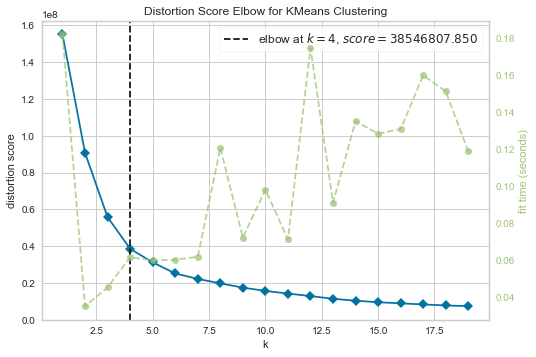

In [29]:
model = KMeans()
vis = KElbowVisualizer(model, k=(1, 20))
vis.fit(X)
vis.show()
plt.show()

### Test

In [30]:
# instatiate KMeans class and set the number of clusters
km_model = KMeans(n_clusters=4, random_state=10)

# call fit method with data 
km = km_model.fit_predict(X)

# coordinates of cluster center
centroids = km_model.cluster_centers_ 

# cluster label for each data point
labels = km_model.labels_ 

km = km.tolist()


In [31]:
len(list(itertools.combinations(range(len(cpo["Person"])),2)))
len(cpo["Person"])

4088

In [32]:
len(km)

4088

In [33]:
# #km has the clusters that each character belongs to

# labels = cpo["Person"].to_list()

# clust = list(zip(km, labels))

# #returns list of tuples

In [34]:
# clust[0][1]

In [35]:
# c1 = [clust[i][1] for i in range(len(clust)) if(clust[i][0] == 1)]
# len(c1)
c1_idx = [i for i in range(len(km)) if(km[i] == 0)]

#drop duplicate persons in same cluster
check_dupli = []
c1_indices = []
for i in c1_idx:
    if cpo["Person"][i] not in check_dupli:
        check_dupli.append(cpo["Person"][i])  
        c1_indices.append(i)
#only the first instances get added: ie., freq_norm of only the first occurence of the character
# same problem as with h_clust - 
#some data is lost, because only the first few chapters get visualised properly, probably
        
"""Therefore, do multiple scatters as subplots: with each canto: segeregate canto wise via i"""
len(c1_indices)


112

##### cantos seem to be progressively divided between clusters: I think the model just split stuf canto wise
Not when 's were removed though- the records also increased; which is actually weird, because it means that more characters started appearing in more chapters; well the characters also increased(500 nowhere near 800 though - how did 300 of them get lost) - but it is an indordinately disproportionate increase

##### try removing canto column from X: input to kmeans model


In [36]:
cantos = [cpo["Canto"][i] for i in c1_indices]
#c1 indices are all the row indices in 1 cluster, as specified in above cell
# assuming that each val in km array maps to each row in the data: ie., each person record
# cantos is list of all cantos in specified cluster(repetitive-mapped to index)
# cantos

['lakshman',
 'gandharvas',
 'kosal',
 'mahendra',
 'dasaratha',
 'bharat',
 'indra',
 'ikshvaku',
 'lakshman',
 'janasthan',
 'gandharvas',
 'kinnars',
 'jatayus',
 'dasaratha',
 'dandak',
 'ikshvaku',
 'janasthan',
 'krauncha',
 'lakshman',
 'kabandha',
 'dasaratha']

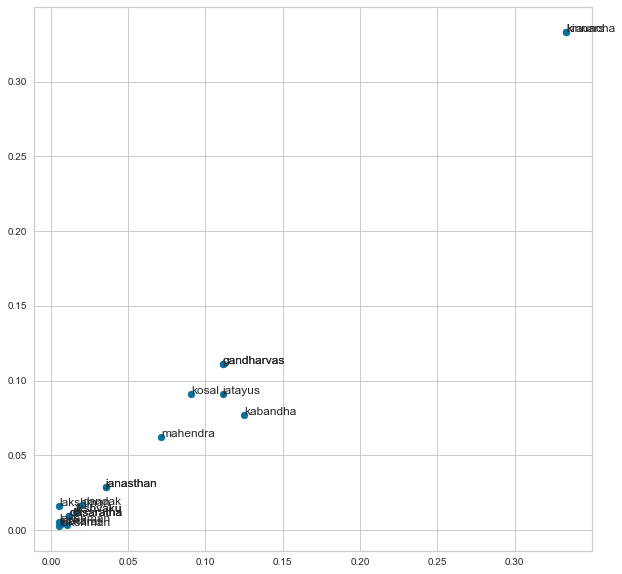

In [72]:
plt.figure(figsize=(10,10))
fro = 260
to = 265
chap = [i for i in range(fro, to)]

#all norm vals for records in clust, filtered by mentioned chaps
x = [cpo["Normalised"][i] for i in c1_indices if cpo["Canto"][i] in chap]
y = [cpo["freq_norm"][i] for i in c1_indices if cpo["Canto"][i] in chap]
l = [cpo["Person"][i] for i in c1_indices if cpo["Canto"][i] in chap]
plt.scatter(x, y)
for i, txt in enumerate(l):
    plt.annotate(txt, (x[i], y[i]))
l


#### In the plot with 5 cluster subplots(or one plot with multiple colored clusters): show animation(on same timeline) of clusters changing over chapters. Since it will be chapter-wise, dont need to worry about same character appearing twice at one point in time. But it might happen that one character hops clusters over time


In [39]:
# # define dictionary for distance measures
# distance_measures = {'euclidean': 0, 'squared euclidean': 1, 'manhattan': 2, 'chebyshev': 3, 
#                     'canberra': 5, 'chi-square': 6}

# # function defined to compute purity score using pyclustering for various distance measures
# def pyPurity(dist_measure):
#     initial_centers = random_center_initializer(X, 3, random_state=5).initialize()
#     # instance created for respective distance metric
#     instanceKm = kmeans(X, initial_centers=initial_centers, metric=distance_metric(dist_measure))
#     # perform cluster analysis
#     instanceKm.process()
#     # cluster analysis results - clusters and centers
#     pyClusters = instanceKm.get_clusters()
#     pyCenters = instanceKm.get_centers()
#     # enumerate encoding type to index labeling to get labels
#     pyEncoding = instanceKm.get_cluster_encoding()
#     pyEncoder = cluster_encoder(pyEncoding, pyClusters, X)
#     pyLabels = pyEncoder.set_encoding(0).get_clusters()
#     # function purity score is defined in previous section
#     return purity_score(y, pyLabels)

# # print results
# for measure, value in distance_measures.items():
#     print(f"The purity score for {measure} distance is {round(pyPurity(value)*100, 2)}%")


### Sense?

In [30]:
cpo.head()

,Canto,Person,Occurences,Normalised,Values,freq_norm,Value_norm,Person_num,CantoTotal,occ_freq
0,0,valmiki,1,0.250000,0.250000,0.111111,0.027778,435,4,0.250000
1,0,rama,3,0.002717,0.008152,0.002151,0.000006,312,4,0.750000
2,1,rama,26,0.002717,0.070652,0.018638,0.000051,312,78,0.333333
3,1,vishnu,1,0.025000,0.025000,0.016667,0.000417,466,78,0.012821
4,1,kaikeyi,1,0.014493,0.014493,0.008475,0.000123,161,78,0.012821


In [32]:
# cpo.to_csv("../data/csv/clusts.csv", index=False)

In [35]:
X = cpo.iloc[:, [5, 9]]

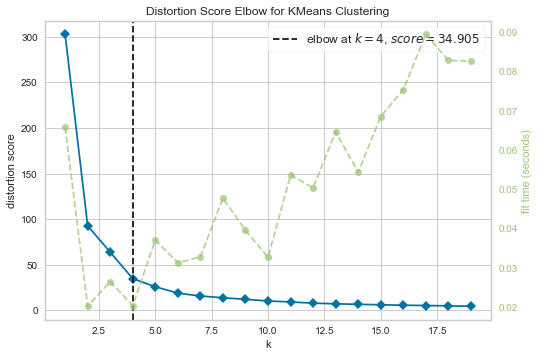

In [36]:
model = KMeans()
vis = KElbowVisualizer(model, k=(1, 20))
vis.fit(X)
vis.show()
plt.show()

In [37]:
# instatiate KMeans class and set the number of clusters
km_model = KMeans(n_clusters=4, random_state=10)

# call fit method with data 
km = km_model.fit_predict(X)

# coordinates of cluster center
centroids = km_model.cluster_centers_ 

# cluster label for each data point
labels = km_model.labels_ 

km = km.tolist()

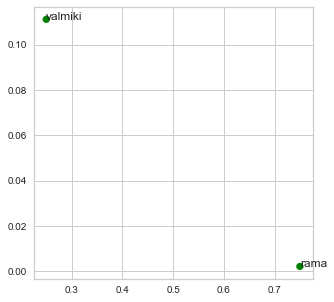

['valmiki', 'rama']


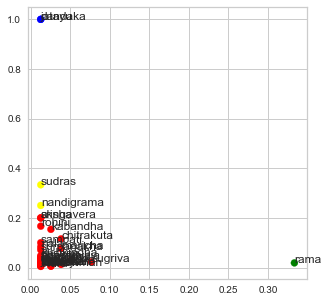

['rama', 'vishnu', 'kaikeyi', 'lakshman', 'janak', 'rohini', 'sringavera', 'ganga', 'bharadvaja', 'chitrakuta', 'ayodhya', 'dandaka', 'agastya', 'indra', 'surpanakha', 'dushan', 'maricha', 'ravan', 'jatayu', 'sita', 'kabandha', 'pampa', 'hanuman', 'wind-god', 'sugriva', 'bali', 'kishkindha', 'sampati', 'aksha', 'nala', 'lanka', 'vibhishan', 'nandigrama', 'brahma', 'sudras']


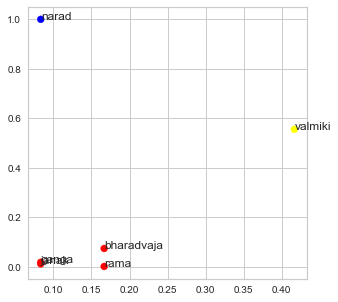

['valmiki', 'ganga', 'bharadvaja', 'rama', 'narad', 'janak']


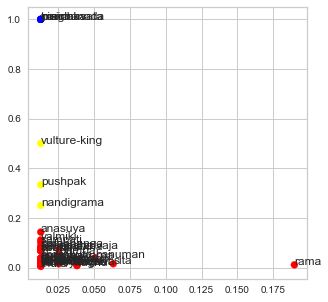

['dasaratha', 'sita', 'rama', 'raghu', 'visvamitra', 'janak', 'kaikeyi', 'guha', 'ganga', 'bharadvaja', 'chitrakuta', 'bharat', 'nandigrama', 'dandak', 'anasuya', 'sarabhanga', 'indra', 'agastya', 'viradha', 'panchavata', 'surpanakha', 'trisira', 'khara', 'ravan', 'maricha', 'vulture-king', 'kabandha', 'pampa', 'sugriva', 'bali', 'tara', 'sampati', 'hanuman', 'mainaka', 'lanka', 'asoka', 'nala', 'vibhishan', 'kumbhakarna', 'meghanada', 'pushpak', 'brahma', 'wind-god', 'valmiki']


In [38]:
k = 4 #number of clusters

#all norm vals for records in clust, filtered by mentioned chaps


# all indices in a chap; construct km list with clust number for that; filter km list
cols = {0:'red', 1: 'blue', 2:'green', 3:'yellow'}
    
for cha in range(0, 4):
    km_clusts = {}
    chap_idx = [i for i in range(len(km)) if (cpo["Canto"][i] == cha)] # allindices in chap
   
        #this giveslist of all indices foreach cluster and particular chapter
        # from this dict of 4 clusters that will change with each chapter inside a loop: obtain x,y,l
    color = [cols[km[i]] for i in chap_idx]
    # for i in chap_idx:
    #     cluster = km[i]
    #     color.append(cols[cluster])
    x = [cpo["occ_freq"][i] for i in chap_idx] #imp of char:chap
    y = [cpo["freq_norm"][i] for i in chap_idx]#imp(chap:char)
    l = [cpo["Person"][i] for i in chap_idx]   

    # stupid adjust text package: needs-> plt.text(x, y, l)
    # texts = []
    # for x, y, s in zip(x, y, l):
    #     texts.append(plt.text(x, y, s))
    # fig, ax = plt.subplots()
    plt.figure(figsize=(5,5))
    plt.scatter(x, y, c=color)
    for i, txt in enumerate(l):
        plt.annotate(txt, (x[i], y[i]))
    # adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    # ta.allocate_text(fig,ax ,x,y,
    #             l,
    #             x_scatter=x, y_scatter=y,
    #             textsize=10)

#adjusting is still too cluttered: shifting to hovering
    
    plt.show()
    print(l)


In [146]:
"""Annotate Adjust"""

# np.random.seed(0)
# x, y = np.random.random((2,30))
# fig, ax = plt.subplots()
# ax.scatter(x, y, c='b')
# text_list = [f'Text{i}' for i in range(len(x))]
# ta.allocate_text(fig,ax,x,y,
#                 text_list,
#                 x_scatter=x, y_scatter=y,
#                 textsize=10)
# plt.show()

'Annotate Adjust'